In [1]:
import cv2 
from matplotlib import pyplot as plt
import numpy as np
import math
import time

In [2]:
# Creates the kernels
def getGaussianKernels(size, sigma = 1):
    kernel = [[0] * size for _ in range(size)]
    center = size // 2

    total = 0
    for x in range(size):
        for y in range(size):
            kernel[x][y] = math.exp(-((x - center)**2 + (y - center)**2) / (2 * sigma**2))
            total += kernel[x][y]

    # Normalize the kernel
    for x in range(size):
        for y in range(size):
            kernel[x][y] /= total

    print(kernel)

    return kernel

In [3]:
def importImages(name):

    image_info = {}
    
    # original_image = cv2.imread('cameraman.jpg')
    noisy_image = cv2.imread(name)


    # cv2.imshow('Image1', original_image)
#     cv2.imshow('Input', noisy_image)

    height, width, channels = noisy_image.shape

    cv2.waitKey(0)
    cv2.destroyAllWindows()


    image_info['height'] = height
    image_info['width'] = width
    image_info['channels'] = channels
    image_info['image'] = noisy_image # list of list image values


    noisy_image = cv2.cvtColor(noisy_image, cv2.COLOR_BGR2GRAY)
    image_info['bw_image'] = noisy_image #single string image
    
    return image_info


In [4]:
def buildImage(pixel_values, dimension, original_image, bw_image):

    image_array = np.array(pixel_values).reshape((dimension, dimension))

    image_array = np.uint8(image_array)

    # Create the image using cv2
    final_image = cv2.resize(image_array, (dimension, dimension), interpolation=cv2.INTER_NEAREST)

    # Display the image
    # cv2.imshow('original input', original_image)
#     cv2.imshow('black and white input', bw_image)
#     cv2.imshow('Output', final_image)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

    return final_image

In [5]:
#print images: 
def printImages(original_image, final_image): 
    
    plt.figure(figsize=(12, 12))  # Set the size of the figure

    plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot number 1
    plt.imshow(original_image, cmap='gray')
    plt.axis('off')  # Turn off axis
    plt.title('Original Image')
    
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, plot number 2
    plt.imshow(final_image, cmap='gray')
    plt.axis('off')  # Turn off axis
    plt.title('Final Image')
    

"""
This function will be converted to C++ using the AXI stream interface and loop fission optimization to be executing in
Vitis HLS
"""

def gaussianBlur(image, kernel):
        
    down = 0 #determines what the kernel can compute. 
    up = 0
    right = 0 
    left = 0
    kernel_center = int((len(kernel) - 1)/2)

    new_image = []
    for row in range(len(image)):

        new_row = []

        for col in range(len(image[row])):
            
            # reinitializes the value of the sum to 0
            sum = 0

            # center
            sum += (kernel[kernel_center][kernel_center] * image[row][col])

            # check down
            if((row + 1) >= len(image)):
                down = 0 
            else:
                for i in range(kernel_center, 0-1, -1):
                    if (row + i < len(image)):
                        down = i
                        break
                for i in range(down):
                    sum += (kernel[kernel_center + i + 1][kernel_center] * image[row + i + 1][col])
                

            # check up
            if((row - 1) < 0):
                up = 0
            else:
                for i in range(kernel_center, 0-1, -1):
                    if (row - i >= 0):
                        up = i
                        break
                for i in range(up):
                    sum += (kernel[kernel_center - i - 1][kernel_center] * image[row - i - 1][col])


            # check right
            if((col+1) >= len(image[row])):
                right = 0
            else:
                for i in range(kernel_center, 0-1, -1):
                    if (col + i < len(image[row])):
                        right = i
                        break
                for i in range(right):
                    sum += (kernel[kernel_center][kernel_center + i + 1] * image[row][col + i + 1])


            # check left
            if((col-1) < 0):
                left = 0
            else:
                for i in range(kernel_center, 0-1, -1):
                    if((col - i) >= 0):
                        left = i
                        break
                for i in range(left):
                    sum += (kernel[kernel_center][kernel_center - i - 1] * image[row][col - i - 1])


            #bottom right square 
            if (down > 0) and (right > 0):
                for i in range(down):
                    for j in range(right):
                        sum += (kernel[kernel_center + i + 1][kernel_center + j + 1] * image[row + i + 1][col + j + 1])


            #bottom left square 
            if (down > 0) and (left > 0):
                for i in range(down):
                    for j in range(left):
                        sum += (kernel[kernel_center + i + 1][kernel_center - j - 1] * image[row + i + 1][col - j - 1])


            #top right square 
            if (up > 0) and (right > 0):
                for i in range(up):
                    for j in range(right):
                        sum += (kernel[kernel_center - i - 1][kernel_center + j + 1] * image[row - i - 1][col + j + 1])


            #top left square 
            if (up > 0) and (left > 0):
                for i in range(up):
                    for j in range(left):
                        sum += (kernel[kernel_center - i - 1][kernel_center - j - 1] * image[row - i - 1][col - j - 1])


            
            new_row.append(sum) # per column
            del sum

            print("pixel " + str(row) + " " + str(col) + " complete")


        new_image.append(new_row) # per row
        del new_row


    return new_image


In [6]:
#hardware implementation using set multiplication method. 

def send2Hardware(window, kernel):
    #converting window mat into string
    sum = 0
    for i in range(len(window)):
        for j in range(len(window)):
            sum += window[i][j] * kernel[i][j]
            
            
    return sum    


def gaussianBlur(image, kernel):
    
    down = 0 #determines what the kernel can compute. 
    up = 0
    right = 0 
    left = 0
    kernel_center = int((len(kernel) - 1)/2)
    
    window = []
    for i in range(len(kernel)):
        row = []
        
        for j in range(len(kernel)):
            row.append(0)

        window.append(row)
    
    new_image = []
    for row in range(len(image)):
        
        new_row = []
        
        for col in range(len(image[row])):
            
            # reinitializes the value of the sum to 0
            sum = 0
            
            #center
            window[kernel_center][kernel_center] = image[row][col]

            # check down
            if((row + 1) >= len(image)):
                down = 0 
            else:
                for i in range(kernel_center, 0-1, -1):
                    if (row + i < len(image)):
                        down = i
                        break
                for i in range(down):
                    window[kernel_center + i + 1][kernel_center] = image[row + i + 1][col]
                

            # check up
            if((row - 1) < 0):
                up = 0
            else:
                for i in range(kernel_center, 0-1, -1):
                    if (row - i >= 0):
                        up = i
                        break
                for i in range(up):
                    window[kernel_center - i - 1][kernel_center] = image[row - i - 1][col]


            # check right
            if((col+1) >= len(image[row])):
                right = 0
            else:
                for i in range(kernel_center, 0-1, -1):
                    if (col + i < len(image[row])):
                        right = i
                        break
                for i in range(right):
                    window[kernel_center][kernel_center + i + 1] = image[row][col + i + 1]


            # check left
            if((col-1) < 0):
                left = 0
            else:
                for i in range(kernel_center, 0-1, -1):
                    if((col - i) >= 0):
                        left = i
                        break
                for i in range(left):
                    window[kernel_center][kernel_center - i - 1] = image[row][col - i - 1]


            #bottom right square 
            if (down > 0) and (right > 0):
                for i in range(down):
                    for j in range(right):
                        window[kernel_center + i + 1][kernel_center + j + 1] = image[row + i + 1][col + j + 1]


            #bottom left square 
            if (down > 0) and (left > 0):
                for i in range(down):
                    for j in range(left):
                        window[kernel_center + i + 1][kernel_center - j - 1] = image[row + i + 1][col - j - 1]


            #top right square 
            if (up > 0) and (right > 0):
                for i in range(up):
                    for j in range(right):
                        window[kernel_center - i - 1][kernel_center + j + 1] = image[row - i - 1][col + j + 1]


            #top left square 
            if (up > 0) and (left > 0):
                for i in range(up):
                    for j in range(left):
                        window[kernel_center - i - 1][kernel_center - j - 1] = image[row - i - 1][col - j - 1]


            
            new_row.append(send2Hardware(window, kernel)) 

            print("pixel " + str(row) + " " + str(col) + " complete")


        new_image.append(new_row) # per row
        del new_row


    return new_image

In [7]:
# grabs images
image_info = importImages('barb_noisy.jpg')

In [8]:
# gets the gaussian kernel
image_info['kernel'] = getGaussianKernels(3, 1) # increasing the size of the kernel from 5 to 7 will drastically increase time

[[0.0751136079541115, 0.12384140315297394, 0.0751136079541115], [0.12384140315297394, 0.20417995557165805, 0.12384140315297394], [0.0751136079541115, 0.12384140315297394, 0.0751136079541115]]


In [9]:
# blurs the image (This part is to be converted into HLS
start = time.time()
image_info['gaussian_blur'] = gaussianBlur(image_info['bw_image'], image_info['kernel'])
stop = time.time()

pixel 0 0 complete
pixel 0 1 complete
pixel 0 2 complete
pixel 0 3 complete
pixel 0 4 complete
pixel 0 5 complete
pixel 0 6 complete
pixel 0 7 complete
pixel 0 8 complete
pixel 0 9 complete
pixel 0 10 complete
pixel 0 11 complete
pixel 0 12 complete
pixel 0 13 complete
pixel 0 14 complete
pixel 0 15 complete
pixel 0 16 complete
pixel 0 17 complete
pixel 0 18 complete
pixel 0 19 complete
pixel 0 20 complete
pixel 0 21 complete
pixel 0 22 complete
pixel 0 23 complete
pixel 0 24 complete
pixel 0 25 complete
pixel 0 26 complete
pixel 0 27 complete
pixel 0 28 complete
pixel 0 29 complete
pixel 0 30 complete
pixel 0 31 complete
pixel 0 32 complete
pixel 0 33 complete
pixel 0 34 complete
pixel 0 35 complete
pixel 0 36 complete
pixel 0 37 complete
pixel 0 38 complete
pixel 0 39 complete
pixel 0 40 complete
pixel 0 41 complete
pixel 0 42 complete
pixel 0 43 complete
pixel 0 44 complete
pixel 0 45 complete
pixel 0 46 complete
pixel 0 47 complete
pixel 0 48 complete
pixel 0 49 complete
pixel 0 50

In [10]:
# rebuilds the final image
image_info['final_image'] = buildImage(image_info['gaussian_blur'], image_info['height'], image_info['image'], image_info['bw_image'])

Execution time for PS: 209.9009747505188 seconds using a 5x5 gaussian kernel


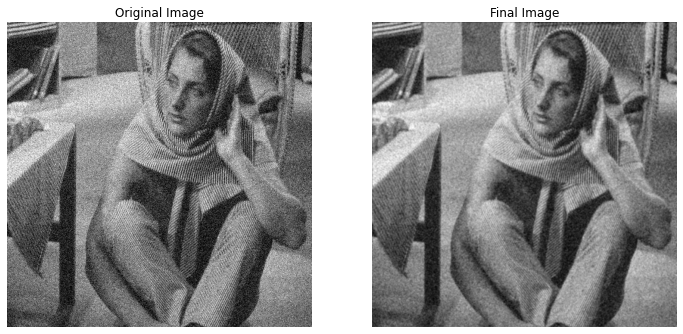

In [11]:
#output the images in matplotlib
printImages(image_info['bw_image'], image_info['final_image'])
print("Execution time for PS: " + str((stop - start)) + " seconds using a 5x5 gaussian kernel")